In [127]:
# Extract results

In [128]:
### Imports 
import os
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
import time
import json

import pandas as pd

sys.path.append('../../')
from script.conversion.bison.coordinates import rd_to_utm
from mnms.graph.layers import PublicTransportLayer, MultiLayerGraph, OriginDestinationLayer, SharedVehicleLayer
from mnms.generation.roads import generate_pt_line_road, generate_one_zone
from mnms.generation.layers import generate_layer_from_roads
from mnms.vehicles.veh_type import Tram, Metro, Bus, Bike
from mnms.generation.zones import generate_one_zone
from mnms.mobility_service.public_transport import PublicTransportMobilityService
from mnms.mobility_service.vehicle_sharing import VehicleSharingMobilityService
from mnms.time import TimeTable, Dt, Time
from mnms.io.graph import load_graph, save_graph, load_odlayer, save_transit_links
from mnms.tools.render import draw_roads, draw_line, draw_odlayer, draw_path, draw_veh_activity
#from mnms.tools.geometry import points_in_polygon, get_bounding_box
from mnms.time import Time

In [129]:
### Parameters

# Files and directories
f = open('params.json')
params = json.load(f)

current_dir = os.getcwd()
indir = current_dir + '/inputs/'
outdir = current_dir + '/outputs/'

#coord_csv_filepath = indir + 'KV1_GVB_2609_2/Csv/POINT.csv' # file with coordinates of the network
#amsterdam_json_filepath = indir + 'new_network.json' # mlgraph with the road network only
#amsterdam_json_filepath_pt_transit = indir + "network_pt_transit.json"
#transit_path = indir + "transit.json"

In [130]:
### Load network

mmgraph_pt = load_graph(indir + params["fn_network"])
df_stations = pd.read_csv(indir+params['fn_emoped_st_init'])

#df_emoped1 = pd.read_csv(indir + 'init_pos_emoped.csv')
#df_emoped2 = pd.read_csv(indir + 'init_pos_emoped.csv')

### Load demand

df_dmd = pd.read_csv(indir + params['fn_demand'], sep=";")

### Load odlayer
odlayer = load_odlayer(indir + params["fn_odlayer"])
x_od = []
y_od = []
for i in odlayer.origins.items():
    x = i[1][0]
    y = i[1][1]
    x_od.append(x)
    y_od.append(y)

In [131]:
## Load results

df_emoped1 = pd.read_csv(outdir+'emoped1_veh.csv', sep=";")
df_path = pd.read_csv(outdir+'path.csv', sep=";")
df_users = pd.read_csv(outdir+'users.csv', sep=";")

In [132]:
# Look vehicle trajectory
"""veh_id = 130
df = df_emoped1[df_emoped1["ID"] == int(veh_id)]
list_pos_emoped = np.zeros((len(df['POSITION']),2))
for i, row in enumerate(df['POSITION']):
    pos = row.split(' ')
    #plt.text(float(pos[0]), float(pos[1]), row.TIME)
    list_pos_emoped[i,:] = [float(pos[0]), float(pos[1])]"""

'veh_id = 130\ndf = df_emoped1[df_emoped1["ID"] == int(veh_id)]\nlist_pos_emoped = np.zeros((len(df[\'POSITION\']),2))\nfor i, row in enumerate(df[\'POSITION\']):\n    pos = row.split(\' \')\n    #plt.text(float(pos[0]), float(pos[1]), row.TIME)\n    list_pos_emoped[i,:] = [float(pos[0]), float(pos[1])]'

In [133]:
len(df_dmd)

7925

In [134]:
# Look O/D for users wihtout paths
"""list_nomatch = []
list_origins = []
list_destinations = []
for i, row in df_path_notax[:].iterrows():
    if pd.isna(row['PATH']):
        list_nomatch.append(row['ID'])
        user = df_dmd[df_dmd['ID']==row['ID']]
        list_origins.append([float(o) for o in user['ORIGIN'].iloc[0].split(' ')])
        list_destinations.append([float(o) for o in user['DESTINATION'].iloc[0].split(' ')])"""

"list_nomatch = []\nlist_origins = []\nlist_destinations = []\nfor i, row in df_path_notax[:].iterrows():\n    if pd.isna(row['PATH']):\n        list_nomatch.append(row['ID'])\n        user = df_dmd[df_dmd['ID']==row['ID']]\n        list_origins.append([float(o) for o in user['ORIGIN'].iloc[0].split(' ')])\n        list_destinations.append([float(o) for o in user['DESTINATION'].iloc[0].split(' ')])"

In [135]:
"""id_user = '1066750-1'
o_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['ORIGIN'].iloc[0].split(' ')]
d_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['DESTINATION'].iloc[0].split(' ')]

dist_o = [(o_user[0]-x)**2 + (o_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]
dist_d = [(d_user[0]-x)**2 + (d_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]
print(np.argmin(dist_o), np.argmin(dist_d))"""

"id_user = '1066750-1'\no_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['ORIGIN'].iloc[0].split(' ')]\nd_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['DESTINATION'].iloc[0].split(' ')]\n\ndist_o = [(o_user[0]-x)**2 + (o_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]\ndist_d = [(d_user[0]-x)**2 + (d_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]\nprint(np.argmin(dist_o), np.argmin(dist_d))"

In [136]:
#polygon = np.asarray([
#    [628000, 5.81e6],
#    [632500, 5.808e6],
#    [634000, 5.8055e6],
#    [634000, 5.803e6],
#    [633000, 5.801e6],
#    [630500, 5.7995e6],
#    [629000, 5.8e6],
#    [625500, 5.8e6],
#    [625500, 5.803e6],
#    [625500, 5.806e6]
#])

polygon = np.asarray(params['polygon_demand'])

In [137]:
x_st = []
y_st = []
for n in df_stations['closest_node']:
    x_st.append(mmgraph_pt.roads.nodes[n].position[0])
    y_st.append(mmgraph_pt.roads.nodes[n].position[1])

In [138]:
x_nodes = []
y_nodes = []
for key in mmgraph_pt.roads.nodes.keys():
    pos = mmgraph_pt.roads.nodes[key].position
    x_nodes.append(pos[0])
    y_nodes.append(pos[1])

In [139]:
print([p - polygon[0,0] for p in polygon[:,0]])
print([p - polygon[0,1] for p in polygon[:,1]])

[0.0, 17000.0, 17000.0, 0.0]
[0.0, 0.0, -17000.0, -17000.0]


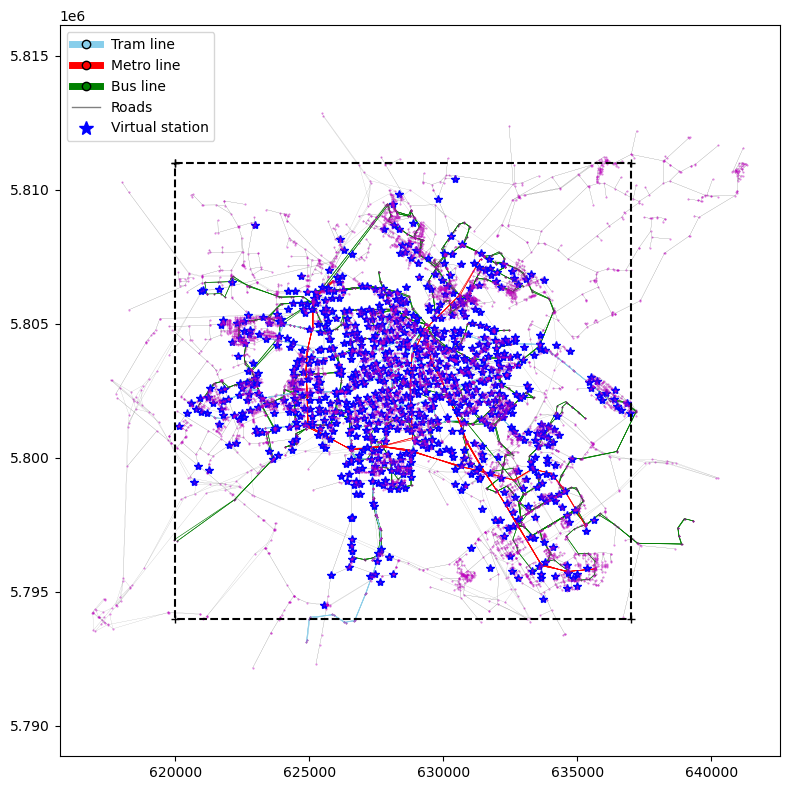

In [140]:
fig, ax = plt.subplots(figsize=(8, 8))

draw_roads(ax, mmgraph_pt.roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)

# Params of the visualization
colors = {'BUS': 'green', 'METRO': 'red', 'TRAM': 'skyblue'}

for layer in mmgraph_pt.layers.values():
    if type(layer) == PublicTransportLayer:
        for name, line in layer.lines.items():
                draw_line(ax, mmgraph_pt, line, color=colors[name[:name.find('_')]], 
                          linkwidth=0.4, nodesize=1, line_label=None, label_size=1, alpha=1., stopmarkeredgewidth=0.1)

#plt.plot(x_od, y_od, 'dk', alpha=0.4)

plt.plot(x_st, y_st, '*b')

plt.plot(x_nodes, y_nodes, '.m', alpha=0.5, markersize=1)

#plt.plot(list_pos_emoped[:,0], list_pos_emoped[:,1], ':.')

"""for o,d in zip(list_origins, list_destinations):
    plt.plot([o[0], d[0]], [o[1], d[1]], 'm:', alpha=0.2)
    plt.plot(d[0], d[1], 'dm', alpha=0.2)
    plt.plot(o[0], o[1], 'om', alpha=0.2)"""

#plt.plot([o_user[0], d_user[0]], [o_user[1], d_user[1]], 'o-')
x=list(polygon[:,0])
x.append(polygon[0,0])
y=list(polygon[:,1])
y.append(polygon[0,1])
plt.plot(x, y, '+--k')

legend = [Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='skyblue', linewidth=5,
            label='Tram line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='red', linewidth=5,
            label='Metro line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='green', linewidth=5,
            label='Bus line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=0, markeredgecolor='grey', markerfacecolor='grey', color='grey', linewidth=1,
            label='Roads'),
          Line2D([0, 1], [0, 1], marker='*', markersize=10, color='b', linewidth=0,
            label='Virtual station')]

legend = plt.legend(handles=legend)
#plt.savefig(params['figdir']+'network.pdf')
#plt.xlim([627000,628000])
#plt.ylim([5.8095e6, 5.8105e6])

## Modes shares

In [141]:
def emoped_in_modes(modes):
    if pd.isna(modes):
        return False
    else:
        return 'emoped1' in modes

def pt_in_modes(modes):
    if pd.isna(modes):
        return False
    else:
        return ('BUS' in modes) or ('TRAM' in modes) or ('METRO' in modes)

def calculate_mode_shares(df_paths, list_id):
    emoped_only = 0
    pt_only = 0
    combined = 0
    for id in list_id[:]:
        paths = df_paths[df_paths['ID']==id]
        path = paths.iloc[-1]
        modes = path['SERVICES']
        if emoped_in_modes(modes):
            if pt_in_modes(modes):
                combined+=1
            if (not pt_in_modes(modes)):
                emoped_only+=1
        else:
                pt_only+=1
    sum = len(list_id)
    return (emoped_only/sum, pt_only/sum, combined/sum)

In [142]:
list_id = df_path['ID'].unique()

print(calculate_mode_shares(df_path, list_id))

(0.15545741324921136, 0.8147634069400631, 0.029779179810725552)


In [143]:
# (0.05962495601025589, 0.9038761248805993, 0.03649891910914484) no rebalancing
# (0.07304811221155297, 0.8939218742144689, 0.03303001357397818)

## TTT/TTD

In [144]:
def calculate_tt_td(list_id, df_users):
    TTT = 0
    TTD = 0
    count = 0
    for id in list_id:
        df = df_users[df_users['ID']==id]
        if len(df)>0:
            TTT += Time(df['TIME'].iloc[-1]).to_seconds() - Time(df['TIME'].iloc[0]).to_seconds()
            TTD += df['DISTANCE'].iloc[-1]
            count += 1
    return (TTT/60/count, TTD*1e-3/count)

In [145]:
# Compute total travel time/distance

print(calculate_tt_td(list_id, df_users))

(18.997576583210652, 3.8960721708394814)


In [146]:
df_emoped1[df_emoped1.STATE!='STOP']

,TIME,ID,TYPE,LINK,POSITION,SPEED,STATE,DISTANCE,PASSENGERS
600,16:01:00.00,211,Bike,EMOPEDLayer1_m46356348 EMOPEDLayer1_m46357694,629091.872 5803322.469,8.0,SERVING,480.000,40624.0
601,16:01:00.00,289,Bike,EMOPEDLayer1_m46343839 EMOPEDLayer1_m46346839,627157.197 5803009.774,8.0,SERVING,480.000,70389.0
603,16:01:00.00,382,Bike,EMOPEDLayer1_m46386982 EMOPEDLayer1_m2311116266,627633.822 5803925.192,8.0,SERVING,480.000,93809.0
604,16:01:00.00,389,Bike,EMOPEDLayer1_m46315374 EMOPEDLayer1_m46317740,628054.760 5802270.687,8.0,SERVING,480.000,96422.0
605,16:01:00.00,497,Bike,EMOPEDLayer1_m3175419211 EMOPEDLayer1_m3175419239,629204.837 5804692.609,8.0,SERVING,480.000,130450.0
...,...,...,...,...,...,...,...,...,...
9839,18:23:00.00,506,Bike,EMOPEDLayer1_m46463153 EMOPEDLayer1_m46464900,628628.531 5805917.981,8.0,SERVING,4802.613,156796.0
9841,18:24:00.00,506,Bike,EMOPEDLayer1_m46467085 EMOPEDLayer1_m267046127,628632.724 5806037.281,8.0,SERVING,5282.613,156796.0
9843,18:30:00.00,454,Bike,EMOPEDLayer1_m46457462 EMOPEDLayer1_m46454691,630235.155 5805797.678,8.0,SERVING,10921.203,57993.0
9844,18:31:00.00,454,Bike,EMOPEDLayer1_m46443046 EMOPEDLayer1_m46440585,630192.752 5805371.788,8.0,SERVING,11401.203,57993.0


## Emoped usage

In [147]:
def calculate_emoped_indicators(df_emoped):
    list_emoped = df_emoped['ID'].unique()
    TTD = 0
    TTT = 0
    nb_rides = 0
    for id in list_emoped:
        df = df_emoped[df_emoped['ID']==id]
        TTD += df['DISTANCE'].iloc[-1]
        
        nb_rides_loc = sum(df.STATE=='STOP')-1
        nb_rides += nb_rides_loc
        i_stops = np.where(df.STATE=='STOP')[0]
        for i in range(nb_rides_loc):
            i_start = i_stops[i]+1
            i_stop = i_stops[i+1]
            TTT += str_to_time(df.TIME.iloc[i_stop]) - str_to_time(df.TIME.iloc[i_start])
    return (TTD*1e-3, TTT/3600, nb_rides)

def str_to_time(time_str):
    return sum([float(t)*60**(2-i) for i,t in enumerate(time_str.split(':'))])

In [148]:
ttd, ttt, nb_rides = calculate_emoped_indicators(df_emoped1)

In [149]:
rev = 1*nb_rides + 0.33*ttt*60

In [150]:
print(ttd, ttt, nb_rides, rev)

4014.3060329999967 126.65 1678 4185.67


In [151]:
#3389.869651999997 121.76666666666667 1616 4026.98
#2771.1058549999984 99.73333333333333 1211 3185.7200000000003 no rebalancing

In [152]:
print(ttd/nb_rides, ttt/nb_rides*60, rev/nb_rides)

2.3923158718712734 4.528605482717521 2.494439809296782


In [153]:
df = df_emoped1[(df_emoped1.ID==354)]# & (df_emoped1.STATE=='STOP')]
nb_rides = sum(df.STATE=='STOP')-1
tt=0
i_stops = np.where(df.STATE=='STOP')[0]
for i in range(nb_rides):
    i_start = i_stops[i]+1
    i_stop = i_stops[i+1]
    tt += str_to_time(df.TIME.iloc[i_stop]) - str_to_time(df.TIME.iloc[i_start])
    print(i,tt)

0 0.0
1 60.0
2 420.0


In [154]:
df

,TIME,ID,TYPE,LINK,POSITION,SPEED,STATE,DISTANCE,PASSENGERS
245,15:59:00.00,354,Bike,NaN,625565.544 5800885.014,5.5,STOP,0.000,NaN
2200,16:20:00.00,354,Bike,NaN,626983.977 5802873.292,5.5,STOP,0.000,NaN
2731,16:27:00.00,354,Bike,EMOPEDLayer1_m2284093726 EMOPEDLayer1_m2303700363,626759.890 5803223.481,8.0,SERVING,480.000,4591.0
2811,16:28:00.00,354,Bike,EMOPEDLayer1_m2284093726 EMOPEDLayer1_m2303700363,626704.241 5803201.088,8.0,STOP,539.985,NaN
3253,16:33:00.00,354,Bike,EMOPEDLayer1_m46345942 EMOPEDLayer1_m46343839,626958.731 5802932.982,8.0,SERVING,1019.985,87898.0
3341,16:34:00.00,354,Bike,EMOPEDLayer1_m46336907 EMOPEDLayer1_m949979531,626770.031 5802638.640,8.0,SERVING,1499.985,87898.0
3425,16:35:00.00,354,Bike,EMOPEDLayer1_m450950927 EMOPEDLayer1_m46328088,626329.426 5802458.156,8.0,SERVING,1979.985,87898.0
3510,16:36:00.00,354,Bike,EMOPEDLayer1_m440673001 EMOPEDLayer1_m46323048,626004.277 5802390.942,8.0,SERVING,2459.985,87898.0
3594,16:37:00.00,354,Bike,EMOPEDLayer1_m46323048 EMOPEDLayer1_m46299022,626022.124 5801911.710,8.0,SERVING,2939.985,87898.0
3671,16:38:00.00,354,Bike,EMOPEDLayer1_m46298630 EMOPEDLayer1_m46289635,625904.142 5801554.394,8.0,SERVING,3419.985,87898.0


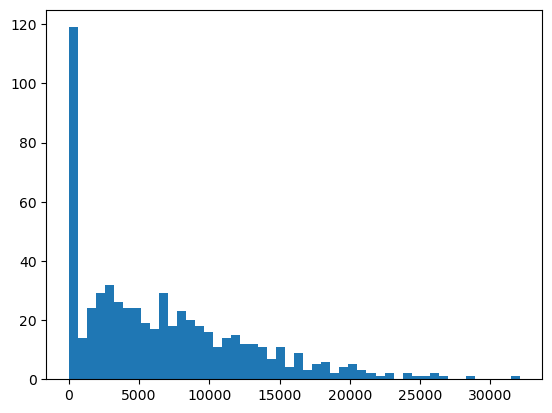

In [155]:
list_emoped = df_emoped1['ID'].unique()
d = []
for id in list_emoped:
    df = df_emoped1[df_emoped1['ID']==id]
    d.append(df['DISTANCE'].iloc[-1])
plt.hist(d, bins=50);

In [156]:
sum([d_==0 for d_ in d])

107

In [157]:
x = []
y = []
x0 = []
y0 = []
list_emoped = df_emoped1['ID'].unique()
TTD = 0
for id in list_emoped:
    df = df_emoped1[df_emoped1['ID']==id]
    p = [float(c) for c in df.POSITION.iloc[-1].split(' ')]
    x.append(p[0])
    y.append(p[1])
    p = [float(c) for c in df.POSITION.iloc[0].split(' ')]
    x0.append(p[0])
    y0.append(p[1])

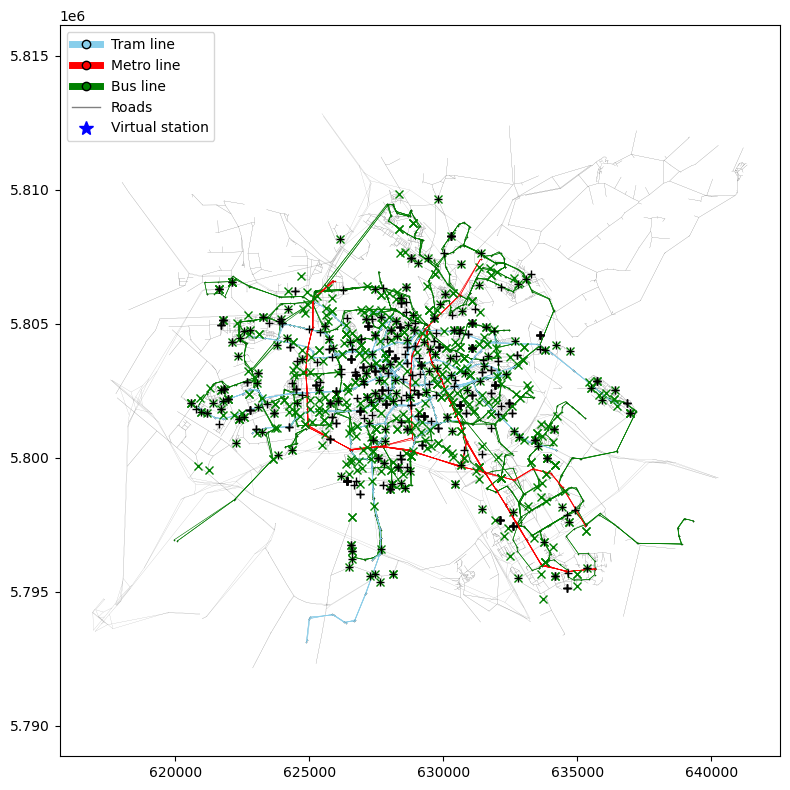

In [158]:
fig, ax = plt.subplots(figsize=(8, 8))

draw_roads(ax, mmgraph_pt.roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)

# Params of the visualization
colors = {'BUS': 'green', 'METRO': 'red', 'TRAM': 'skyblue'}

for layer in mmgraph_pt.layers.values():
    if type(layer) == PublicTransportLayer:
        for name, line in layer.lines.items():
                draw_line(ax, mmgraph_pt, line, color=colors[name[:name.find('_')]], 
                          linkwidth=0.4, nodesize=1, line_label=None, label_size=1, alpha=1., stopmarkeredgewidth=0.1)

#plt.plot(x_od, y_od, 'dk', alpha=0.4)

#plt.plot(x_st, y_st, '*b')

#plt.plot(x_nodes, y_nodes, '.m', alpha=0.5, markersize=1)

#plt.plot(list_pos_emoped[:,0], list_pos_emoped[:,1], ':.')

"""for o,d in zip(list_origins, list_destinations):
    plt.plot([o[0], d[0]], [o[1], d[1]], 'm:', alpha=0.2)
    plt.plot(d[0], d[1], 'dm', alpha=0.2)
    plt.plot(o[0], o[1], 'om', alpha=0.2)"""

plt.plot(x0, y0, 'xg')
plt.plot(x, y, '+k')

legend = [Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='skyblue', linewidth=5,
            label='Tram line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='red', linewidth=5,
            label='Metro line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='green', linewidth=5,
            label='Bus line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=0, markeredgecolor='grey', markerfacecolor='grey', color='grey', linewidth=1,
            label='Roads'),
          Line2D([0, 1], [0, 1], marker='*', markersize=10, color='b', linewidth=0,
            label='Virtual station')]

legend = plt.legend(handles=legend)
#plt.savefig(params['figdir']+'network.pdf')
#plt.xlim([627000,628000])
#plt.ylim([5.8095e6, 5.8105e6])

## Station evolution

In [159]:
df_emoped1

,TIME,ID,TYPE,LINK,POSITION,SPEED,STATE,DISTANCE,PASSENGERS
0,15:59:00.00,599,Bike,NaN,636414.650 5802510.894,5.5,STOP,0.0,NaN
1,15:59:00.00,598,Bike,NaN,631772.347 5806813.012,5.5,STOP,0.0,NaN
2,15:59:00.00,597,Bike,NaN,631772.347 5806813.012,5.5,STOP,0.0,NaN
3,15:59:00.00,596,Bike,NaN,632643.138 5806724.043,5.5,STOP,0.0,NaN
4,15:59:00.00,595,Bike,NaN,630266.115 5808261.944,5.5,STOP,0.0,NaN
...,...,...,...,...,...,...,...,...,...
9872,18:54:00.00,567,Bike,NaN,627364.174 5800673.269,5.5,STOP,0.0,NaN
9873,18:54:00.00,568,Bike,NaN,628004.628 5803479.588,5.5,STOP,0.0,NaN
9874,18:54:00.00,569,Bike,NaN,628560.662 5803889.366,5.5,STOP,0.0,NaN
9875,18:54:00.00,570,Bike,NaN,628650.668 5803551.781,5.5,STOP,0.0,NaN


In [160]:
df_emoped1.POSITION == '635811.252 5802339.273'

0       False
1       False
2       False
3       False
4       False
        ...  
9872    False
9873    False
9874    False
9875    False
9876    False
Name: POSITION, Length: 9877, dtype: bool

In [161]:
df_stations['position'] = df_stations.apply(lambda row: '%.3f %.3f'%(row.x_node, row.y_node), axis=1)

In [162]:
df_stations.position

0      620422.006 5801655.356
1      620921.199 5802237.763
2      620575.799 5802043.732
3      620143.643 5801202.518
4      621785.068 5801591.686
                ...          
800    632571.149 5806957.045
801    632643.138 5806724.043
802    631772.347 5806813.012
803    628722.734 5807971.700
804    636414.650 5802510.894
Name: position, Length: 805, dtype: object

In [163]:
station_emoped = np.zeros((len(df_stations), df_stations.nb_emoped.sum()))
nb_emoped_stations = np.zeros((len(df_emoped1.TIME.unique()), len(df_stations)), int)
for i_t, t in enumerate(df_emoped1.TIME.unique()):
    df = df_emoped1[df_emoped1.TIME==t]
    df2 = df[df.STATE=='STOP']
    for i,row in df2.iterrows():
        i_sta = df_stations.index[df_stations.position==row.POSITION][0]
        station_emoped[:, row.ID] = 0
        station_emoped[i_sta, row.ID] = 1
    df3 = df[df.STATE!='STOP']
    for i,row in df3.iterrows():
        station_emoped[:, row.ID] = 0
    nb_emoped_stations[i_t] = station_emoped.sum(axis=1)
    

In [164]:
df_stations.index[df_stations.position==row.POSITION][0]

687

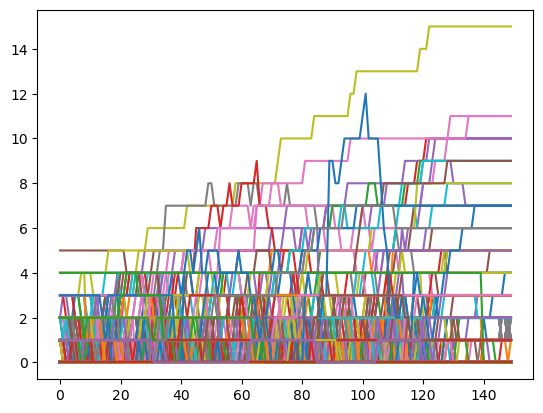

In [165]:
plt.plot(nb_emoped_stations);
#plt.ylim([0,5])

In [166]:
df_emoped1

,TIME,ID,TYPE,LINK,POSITION,SPEED,STATE,DISTANCE,PASSENGERS
0,15:59:00.00,599,Bike,NaN,636414.650 5802510.894,5.5,STOP,0.0,NaN
1,15:59:00.00,598,Bike,NaN,631772.347 5806813.012,5.5,STOP,0.0,NaN
2,15:59:00.00,597,Bike,NaN,631772.347 5806813.012,5.5,STOP,0.0,NaN
3,15:59:00.00,596,Bike,NaN,632643.138 5806724.043,5.5,STOP,0.0,NaN
4,15:59:00.00,595,Bike,NaN,630266.115 5808261.944,5.5,STOP,0.0,NaN
...,...,...,...,...,...,...,...,...,...
9872,18:54:00.00,567,Bike,NaN,627364.174 5800673.269,5.5,STOP,0.0,NaN
9873,18:54:00.00,568,Bike,NaN,628004.628 5803479.588,5.5,STOP,0.0,NaN
9874,18:54:00.00,569,Bike,NaN,628560.662 5803889.366,5.5,STOP,0.0,NaN
9875,18:54:00.00,570,Bike,NaN,628650.668 5803551.781,5.5,STOP,0.0,NaN


In [167]:
nb_emoped_stations[-1,:].sum()

600

In [168]:
nb_emoped_stations[:10,:10]

array([[0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 1, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 0, 0, 1, 1, 1, 2],
       [0, 1, 3, 0, 0, 0, 1, 1, 1, 2],
       [0, 0, 3, 0, 0, 0, 1, 1, 1, 2]])